In [1]:
import os
os.chdir("..")

In [2]:
!ls

MEGANotebooks  envs		    promptsource	   sweeps
Notebooks      gpt-4-all-lang-eval  requirements.txt	   wandb
README.md      images		    requirements_full.txt  xl-sum
analysis       keys		    results		   xtreme
data	       mega		    scripts


In [3]:
import os
import argparse
import sys
import time
import random
import json
import wandb
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
import openai
from mega.data.load_datasets import load_xcopa_dataset
from mega.data.data_utils import choose_few_shot_examples
from mega.eval.eval_cls import evaluate_model
from mega.models.completion_models import gpt3x_completion
from mega.prompting.prompting_utils import load_prompt_template
from mega.prompting.instructions import INSTRUCTIONS
from mega.utils.parser import parse_args
from mega.utils.env_utils import load_env

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import json
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

In [4]:
load_env("gpt4v2")

In [5]:
model = "gpt-35-turbo"

In [6]:
MAX_VAL_SIZE = 500
K = 4
TEMPERATURE = 0

In [7]:
langs = ["ht", "ta"]
lang = langs[0]
filename = glob.glob("data/natural-instructions-2.8/tasks/*xcopa*reasoning*ht*")[0]

In [13]:

with open(filename) as f:
    sni_xcopa = json.load(f)

In [21]:
sni_xcopa

{'Contributors': ['Amirreza Mirzaei'],
 'Source': ['xcopa'],
 'URL': ['https://github.com/cambridgeltl/xcopa'],
 'Categories': ['Cause Effect Classification'],
 'Reasoning': ['Causal Reasoning', 'Commonsense Reasoning'],
 'Definition': ['In this task you are given a premise and two alternatives in Haitian. You must choose the alternative that is more plausibly the cause or effect of the situation described by the premise. The input format is "premise\n(1)alternative_1(2)alternative_2", the output should either be "1" or "2" based on your judgment.'],
 'Input_language': ['Haitian'],
 'Output_language': ['English'],
 'Instruction_language': ['English'],
 'Domains': ['Commonsense', 'Narrative'],
 'Positive Examples': [{'input': 'Atik la te vlope ak papye bul.\n(1)Li te frajil.(2)Li te piti.',
   'output': '1',
   'explanation': 'The first alternative makes more sense because you put object is bubble wrap if they are delicate.'},
  {'input': 'Mwen te vide posh mwen.\n(1)Mwen jwenn yon bout

In [67]:
def construct_sni_prompt(sni_dict, test_example, include_explanation = True, k = 4, system_prompt_role="system",):
    
    def construct_sni_prompt_example(example):
        inp = {"role": "user", "content": example["input"]}
        if include_explanation:
            out = {"role": "assistant", "content": f"{example['explanation']} Hence the answer is, {example['output']}"}
        else:
            out = {"role": "assistant", "content": f"{example['output']}"}
            
        return [inp, out]
    
    system_prompt = {"role": system_prompt_role, "content": f"{sni_dict['Definition'][0]}"}
    examples = []
    pos_nd_neg_exs = sni_dict["Positive Examples"] + sni_dict["Negative Examples"]
    for i in range(min(k, len(pos_nd_neg_exs))):
        examples += (construct_sni_prompt_example(pos_nd_neg_exs[i]))
    random.seed(42)
    random.shuffle(examples)
    
    test_prompt = {
        "role": "user", "content": test_example["input"]
    }
    
    return [system_prompt] + examples + [test_prompt]
    

In [44]:
prompt = construct_sni_prompt(
    sni_xcopa,
    sni_xcopa["Instances"][0]
)
prompt

[{'role': 'system',
  'content': 'In this task you are given a premise and two alternatives in Haitian. You must choose the alternative that is more plausibly the cause or effect of the situation described by the premise. The input format is "premise\n(1)alternative_1(2)alternative_2", the output should either be "1" or "2" based on your judgment.'},
 {'role': 'assistant',
  'content': 'The first alternative makes more sense because finding a ticket in your pocket is more common than finding a gun. Hence the answer is, 1'},
 {'role': 'user',
  'content': 'Foumi yo te anvayi kay la.\n(1)Foumi yo disparèt nan kay la.(2)Foumi yo fin wonje bwa nan kay la.'},
 {'role': 'user',
  'content': 'Atik la te vlope ak papye bul.\n(1)Li te frajil.(2)Li te piti.'},
 {'role': 'assistant',
  'content': 'The second alternative makes less sense than the first one. Hence the answer is, 2'},
 {'role': 'user',
  'content': 'Mwen te vide posh mwen.\n(1)Mwen jwenn yon bout biye.(2)Mwen te jwenn yon zam.'},
 {

In [45]:
out = gpt3x_completion(
    prompt,
    model = model,
    max_tokens = 100,
    temperature=TEMPERATURE
)

In [46]:
out

'The second alternative makes less sense than the first one. Hence the answer is, 1'

In [70]:
langs = ["my", "te", "en"]
include_explanation = True
system_prompt_role = "system"
lang2score = {}
out_dir = "analysis/results/explanations/xcopa/{}"
valid_labels = ["1", "2"]
for lang in langs:
    for seed in [1, 11, 42]:
        out_dir = f"analysis/results/explanations/xcopa/{model}/{lang}/explanations{include_explanation}_system_prompt_role{system_prompt_role}_seed{seed}"
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        filename = glob.glob(f"data/natural-instructions-2.8/tasks/*xcopa*reasoning*{lang}*")[0]
        with open(filename) as f:
            sni_xcopa = json.load(f)
        preds_w_exp = []
        preds_wo_exp = []
        labels = []
        matches = []
        pbar = tqdm(sni_xcopa["Instances"][:500])
        for test_example in pbar:
            num_fs = K
            while True:
                try:
                    prompt = construct_sni_prompt(
                        sni_xcopa,
                        test_example,
                        include_explanation=include_explanation,
                        system_prompt_role=system_prompt_role,
                        k = num_fs
                    )
                    out = gpt3x_completion(
                            prompt,
                            model = model,
                            max_tokens = 100,
                            temperature=TEMPERATURE,
                            timeout=30
                        )
                    break
                except openai.error.Timeout:
                    if num_fs >= 0:
                        num_fs -= 1
                        print(f"Unable To Fit Context Size. Reducing few-size by 1. New Size: {(num_fs)}")
                    else:
                        print("Exausted Everything! Giving Random Prediction Now :(")
                        out = np.random.choice(valid_labels)
                        break
            preds_w_exp.append(out)
            preds_wo_exp.append(out.split(",")[-1].strip().split(".")[0])
            labels.append(test_example["output"][0])
            matches.append(preds_wo_exp[-1] == labels[-1])
            running_acc = np.mean(matches)
            pbar.set_description(f"Accuracy: {running_acc}")

        results_df = pd.DataFrame({"Label": labels, "Prediction": preds_wo_exp, "Match": matches, "Prediction With Explanation": preds_w_exp})
        acc = np.mean(matches)

        results_df.to_csv(f"{out_dir}/predictions.csv")
        results_dict = {
            "model": model,
            "dataset": "xcopa",
            "lang": lang,
            "include_explanation": include_explanation,
            "system_prompt_role": system_prompt_role,
            "seed": seed,
            "metrics": {
                "accuracy": acc
            }
        }
        with open(f"{out_dir}/results.json", "w") as f:
            json.dump(results_dict, f, indent = False)

Accuracy: 0.6666666666666666:   1%|▉                                                                         | 6/500 [00:07<10:15,  1.25s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7192982456140351:  11%|████████▎                                                                | 57/500 [01:40<09:09,  1.24s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.71875:  13%|██████████▊                                                                         | 64/500 [02:19<16:49,  2.31s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7102803738317757:  21%|███████████████▍                                                        | 107/500 [03:42<07:27,  1.14s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7301587301587301:  38%|███████████████████████████▏                                            | 189/500 [05:54<06:24,  1.24s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7042801556420234:  51%|█████████████████████████████████████                                   | 257/500 [07:49<05:23,  1.33s/it]Bad pipe message: %s [b'\xc9\r\x01b\x05fhJ\x12%\xa2t\x8c\xbc-\xe7\x15\xc2\x00\x00\xa6\xc0,', b"\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\x00\n\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01"]
Bad pipe message: %s [b'\n']
Bad pipe message: %s [b'&@\xf1\xd6\xdf\xd6\x1c\xa2', b'\xbe\x15\x8f\xd3\xb8\xdf-\xcb\x00\x00>\xc0\x14\xc0\n\x0

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.695906432748538:  68%|█████████████████████████████████████████████████▉                       | 342/500 [10:02<03:01,  1.15s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.6938775510204082:  69%|█████████████████████████████████████████████████▍                      | 343/500 [10:33<26:42, 10.21s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.6954436450839329:  83%|████████████████████████████████████████████████████████████            | 417/500 [12:36<01:50,  1.34s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.6989010989010989:  91%|█████████████████████████████████████████████████████████████████▌      | 455/500 [13:53<00:55,  1.23s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.694: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [15:18<00:00,  1.84s/it]


In [69]:
langs = ["ht", "ta"]
include_explanation = False
system_prompt_role = "system"
lang2score = {}
out_dir = "analysis/results/explanations/xcopa/{}"
valid_labels = ["1", "2"]
for lang in langs:
    for seed in [1, 11, 42]:
        out_dir = f"analysis/results/explanations/xcopa/{model}/{lang}/explanations{include_explanation}_system_prompt_role{system_prompt_role}_seed{seed}"
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        filename = glob.glob(f"data/natural-instructions-2.8/tasks/*xcopa*reasoning*{lang}*")[0]
        with open(filename) as f:
            sni_xcopa = json.load(f)
        preds_w_exp = []
        preds_wo_exp = []
        labels = []
        matches = []
        pbar = tqdm(sni_xcopa["Instances"][:500])
        for test_example in pbar:
            num_fs = K
            while True:
                try:
                    prompt = construct_sni_prompt(
                        sni_xcopa,
                        test_example,
                        include_explanation=include_explanation,
                        system_prompt_role=system_prompt_role,
                        k = num_fs
                    )
                    out = gpt3x_completion(
                            prompt,
                            model = model,
                            max_tokens = 100,
                            temperature=TEMPERATURE,
                            timeout=30
                        )
                    break
                except openai.error.Timeout:
                    if num_fs >= 0:
                        num_fs -= 1
                        print(f"Unable To Fit Context Size. Reducing few-size by 1. New Size: {(num_fs)}")
                    else:
                        print("Exausted Everything! Giving Random Prediction Now :(")
                        out = np.random.choice(valid_labels)
                        break
            preds_w_exp.append(out)
            preds_wo_exp.append(out.split(",")[-1].strip().split(".")[0])
            labels.append(test_example["output"][0])
            matches.append(preds_wo_exp[-1] == labels[-1])
            running_acc = np.mean(matches)
            pbar.set_description(f"Accuracy: {running_acc}")

        results_df = pd.DataFrame({"Label": labels, "Prediction": preds_wo_exp, "Match": matches, "Prediction With Explanation": preds_w_exp})
        acc = np.mean(matches)

        results_df.to_csv(f"{out_dir}/predictions.csv")
        results_dict = {
            "model": model,
            "dataset": "xcopa",
            "lang": lang,
            "include_explanation": include_explanation,
            "system_prompt_role": system_prompt_role,
            "seed": seed,
            "metrics": {
                "accuracy": acc
            }
        }
        with open(f"{out_dir}/results.json", "w") as f:
            json.dump(results_dict, f, indent = False)

Accuracy: 0.7878787878787878:   7%|████▊                                                                    | 33/500 [00:23<05:35,  1.39it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.8125:  13%|██████████▉                                                                          | 64/500 [01:16<05:16,  1.38it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.782051282051282:  16%|███████████▌                                                              | 78/500 [01:56<05:36,  1.25it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7202797202797203:  29%|████████████████████▌                                                   | 143/500 [03:13<04:16,  1.39it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3
Unable To Fit Context Size. Reducing few-size by 1. New Size: 2


Accuracy: 0.7549019607843137:  41%|█████████████████████████████▍                                          | 204/500 [04:57<03:33,  1.39it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.71900826446281:  48%|███████████████████████████████████▊                                      | 242/500 [05:54<03:08,  1.37it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7137096774193549:  50%|███████████████████████████████████▋                                    | 248/500 [06:29<09:24,  2.24s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.714859437751004:  50%|████████████████████████████████████▎                                    | 249/500 [06:59<45:11, 10.80s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7068403908794788:  61%|████████████████████████████████████████████▏                           | 307/500 [08:11<02:22,  1.35it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7127659574468085:  75%|██████████████████████████████████████████████████████▏                 | 376/500 [09:32<01:40,  1.23it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7165354330708661:  76%|██████████████████████████████████████████████████████▊                 | 381/500 [10:05<05:43,  2.88s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7175572519083969:  79%|████████████████████████████████████████████████████████▌               | 393/500 [10:44<01:38,  1.08it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7153465346534653:  81%|██████████████████████████████████████████████████████████▏             | 404/500 [11:22<01:33,  1.03it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7205542725173211:  87%|██████████████████████████████████████████████████████████████▎         | 433/500 [12:12<00:48,  1.40it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7199170124481328:  96%|█████████████████████████████████████████████████████████████████████▍  | 482/500 [13:18<00:13,  1.38it/s]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7198364008179959:  98%|██████████████████████████████████████████████████████████████████████▍ | 489/500 [13:53<00:19,  1.78s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.7204081632653061:  98%|██████████████████████████████████████████████████████████████████████▌ | 490/500 [14:24<01:44, 10.47s/it]

Unable To Fit Context Size. Reducing few-size by 1. New Size: 3


Accuracy: 0.722: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [15:01<00:00,  1.80s/it]


In [8]:
langcode2lang = {
    "en": "English",
    "ht": "Haitian Creole",
    "ta": "Tamil",
    "sw": "Swahili",
    "ur": "Urdu"
}

In [9]:
system_prompt_role = "system"
langs_list = []
explanations = []
accs = []
seeds = []

for seed in [1, 11, 42]:
    for lang in ["ht", "ta"]:
        for include_explanation in [False, True]:
            out_dir = f"analysis/results/explanations/xcopa/{model}/{lang}/explanations{include_explanation}_system_prompt_role{system_prompt_role}_seed{seed}"
            with open(f"{out_dir}/results.json") as f:
                results = json.load(f)
            accs.append(results["metrics"]["accuracy"])
            explanations.append(int(include_explanation))
            langs_list.append(langcode2lang[lang])
            seeds.append(seed)
        
exp_analysis_df = pd.DataFrame({
    "Language": langs_list,
    "Explanation": explanations,
    "Accuracy": accs,
    "Seed": seeds
})

In [10]:
exp_analysis_df

,Language,Explanation,Accuracy,Seed
0,Haitian Creole,0,0.712,1
1,Haitian Creole,1,0.662,1
2,Tamil,0,0.544,1
3,Tamil,1,0.528,1
4,Haitian Creole,0,0.710,11
5,Haitian Creole,1,0.664,11
6,Tamil,0,0.548,11
7,Tamil,1,0.530,11
8,Haitian Creole,0,0.700,42
9,Haitian Creole,1,0.662,42


In [11]:
save_dir = "analysis/results/explanations/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
exp_analysis_df.to_csv(f"{save_dir}/exp_v_acc.csv")

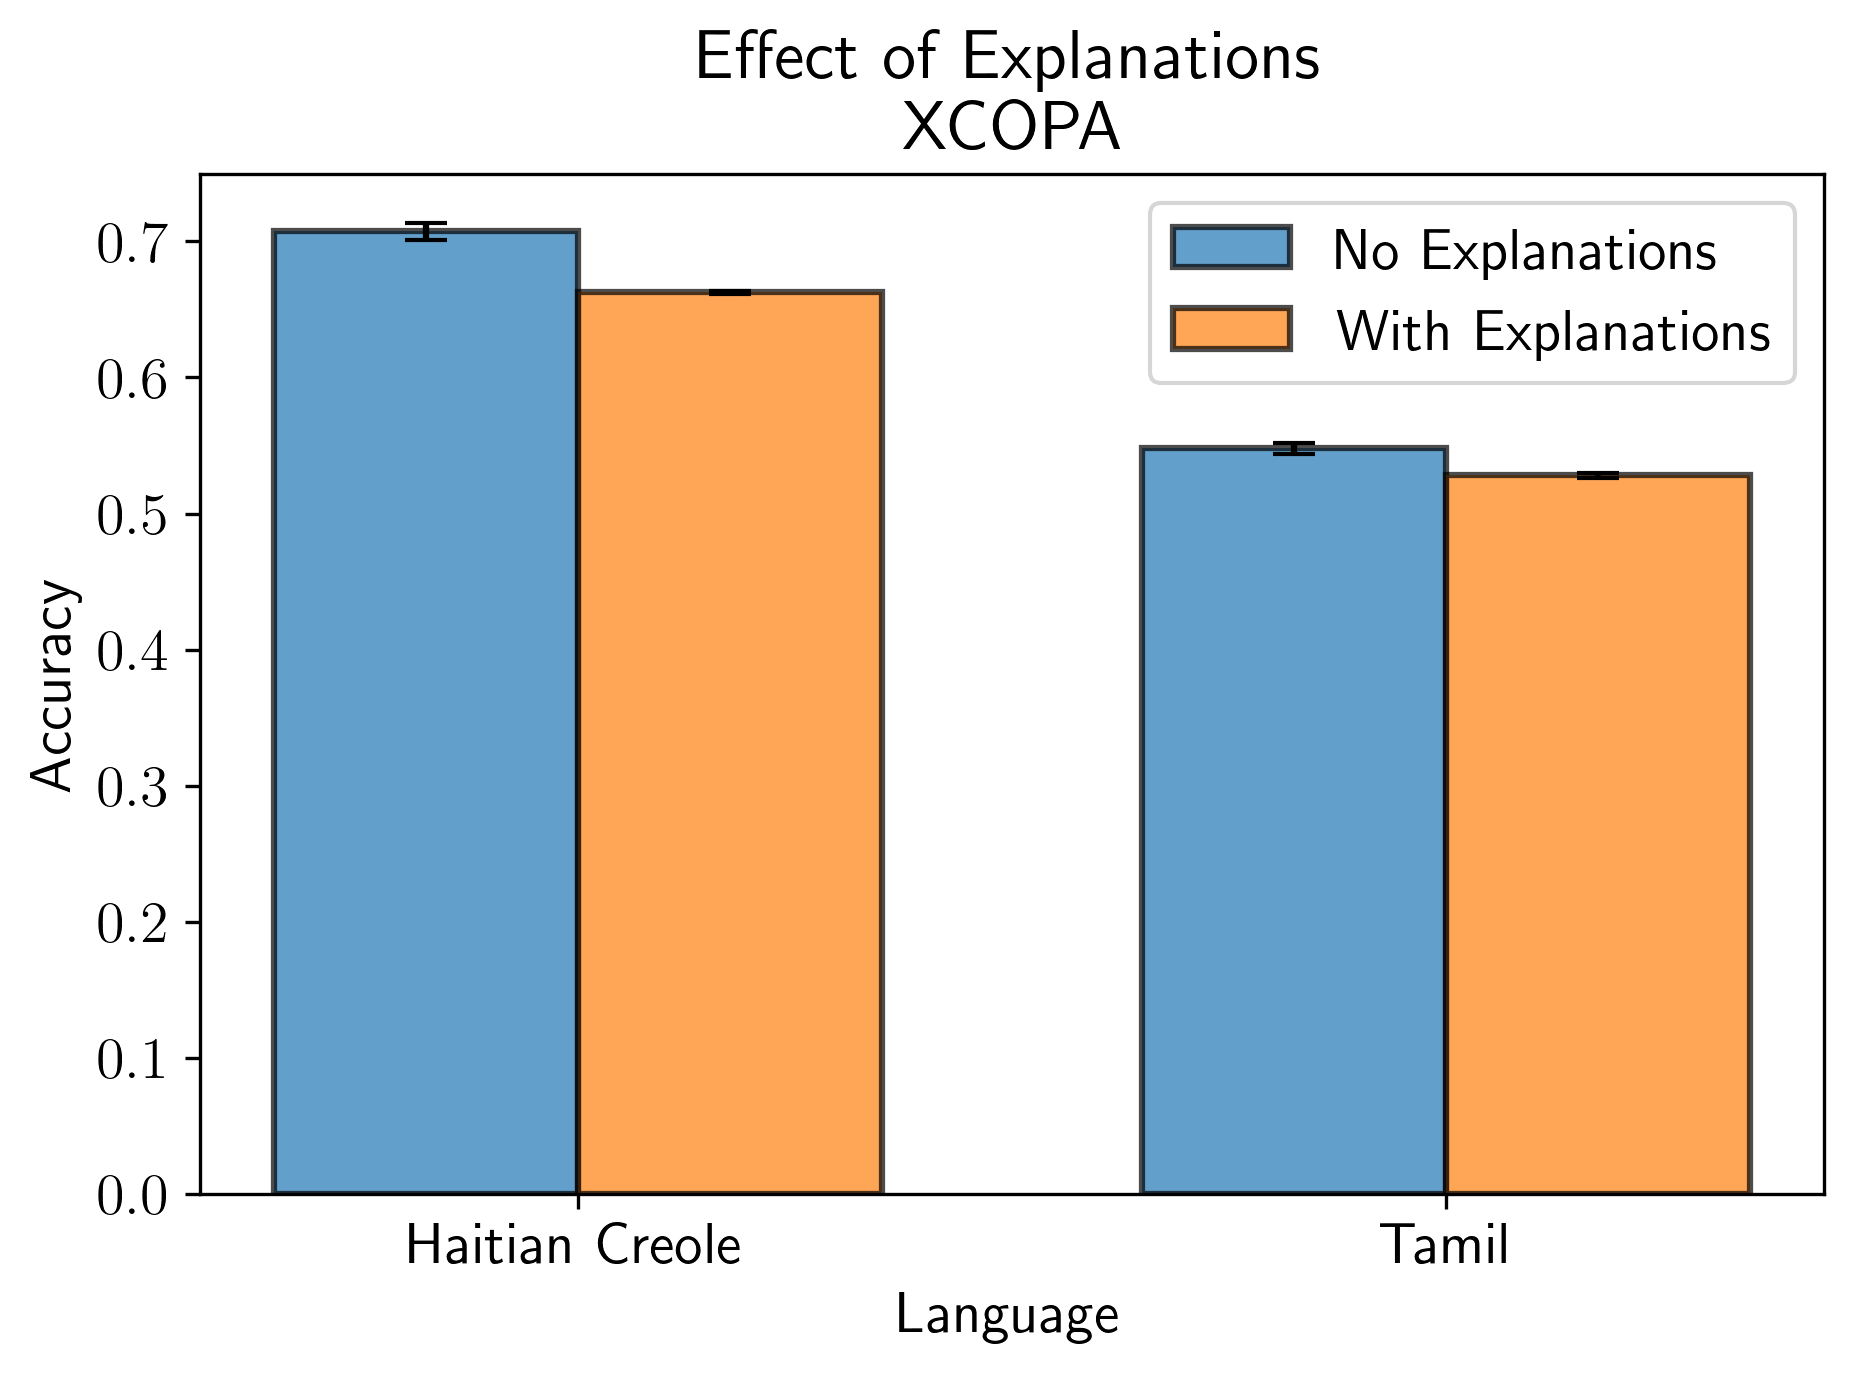

In [12]:
# Group by Language and Explanation, average Accuracy
grouped_df = exp_analysis_df.groupby(['Language', 'Explanation']).mean().reset_index()

# Grouped bar plot
fig, ax = plt.subplots()

bar_width = 0.35
alpha = 0.7
linewidth = 1.5
# Positions of the bars on the x-axis
positions = range(len(grouped_df['Language'].unique()))

# Bar plot for Explanation = 0
rects1 = ax.bar(positions, grouped_df[grouped_df['Explanation'] == 0]['Accuracy'], bar_width,
                alpha=alpha, label='No Explanations', edgecolor="k", linewidth=linewidth)

# Bar plot for Explanation = 1
rects2 = ax.bar([p + bar_width for p in positions], grouped_df[grouped_df['Explanation'] == 1]['Accuracy'], bar_width,
                alpha=alpha, label='With Explanations',edgecolor="k", linewidth=linewidth)

# Add error bars
error_data = exp_analysis_df.groupby(['Language', 'Explanation'])['Accuracy'].std().reset_index()
error_values = error_data[error_data['Explanation'] == 0]['Accuracy'].tolist()
ax.errorbar(positions, grouped_df[grouped_df['Explanation'] == 0]['Accuracy'], yerr=error_values,
            fmt='none', color='black', capsize=5)

error_values = error_data[error_data['Explanation'] == 1]['Accuracy'].tolist()
ax.errorbar([p + bar_width for p in positions], grouped_df[grouped_df['Explanation'] == 1]['Accuracy'], yerr=error_values,
            fmt='none', color='black', capsize=5)

# Set x-axis tick labels as language names
ax.set_xticks([p + bar_width / 2 for p in positions])
ax.set_xticklabels(grouped_df['Language'].unique())

# Set axis labels and title
ax.set_xlabel('Language')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Explanations\nXCOPA')

plt.savefig(f"{save_dir}/xcopa.pdf", bbox_inches = "tight")
plt.savefig(f"{save_dir}/xcopa.png", bbox_inches = "tight", dpi=300)


# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [13]:
categories = xnli_df['Language'].tolist()
group_names = [model for model in models if not xnli_df[model].isna().all()]
bar_width = 0.12
x = np.arange(len(categories))

hatches = {5: '*', 4: ".", 3: "o", 2: "x", 1: "+", 0: "--"}

alpha = 0.7
fig, ax = plt.subplots(figsize=(22.5, 5))
for i, group_name in enumerate(group_names):
    offset = (i - len(group_names) // 2) * bar_width
    l = ax.bar(x + offset, xnli_df[group_name].values.tolist(), width=bar_width, label=group_name, alpha = alpha,
          edgecolor='black', linewidth=1.2)

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Language')
ax.set_ylabel(xnli_df["Metrics"].unique()[0])
ax.set_title('XNLI')
ax.legend(loc = "lower center", ncols = len(models), bbox_to_anchor=(0.5, -0.3))
plt.show()

NameError: name 'xnli_df' is not defined

Bad pipe message: %s [b"M's\x84\xa7\x80\x92c\xa7\xe2\xa6\xf8X\xa4\x86y\x80  \xd3,\x03\xd7_1\xf9\x8f7\x81V\x15\xb0\xa6\xa9ID~efb\xdc\xaa\xb8p\xa9]\xf6\x81\xc3\xecL\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e"]
Bad pipe message: %s [b"U\x80\xea\x86N4B\\\x9dO\xfah\xf5\xae/\x146\xf6\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\